In [1]:
from config import settings

In [2]:
import requests
import numpy as np
import pandas as pd
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.arima import ndiffs
from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from datetime import datetime
%matplotlib inline

In [3]:
from test import ArimaModelBuilder

In [4]:
arima = ArimaModelBuilder()

TypeError: 'ARIMAResultsWrapper' object is not callable

TypeError: 'ARIMAResultsWrapper' object is not callable

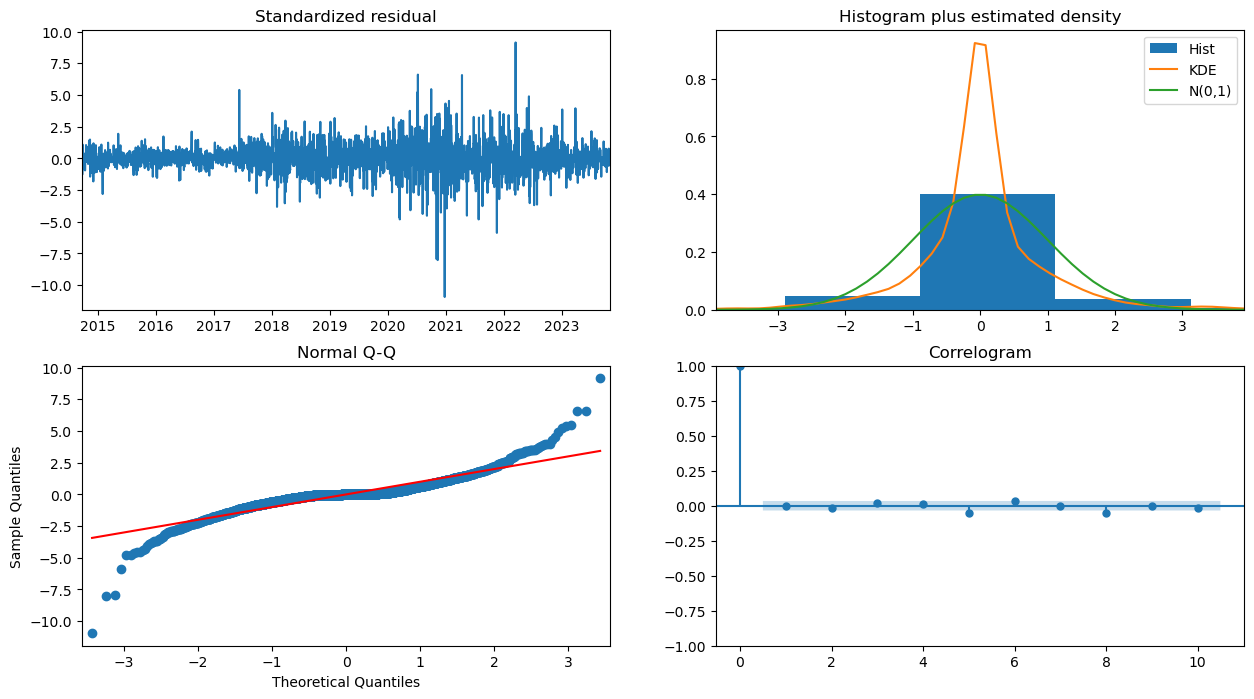

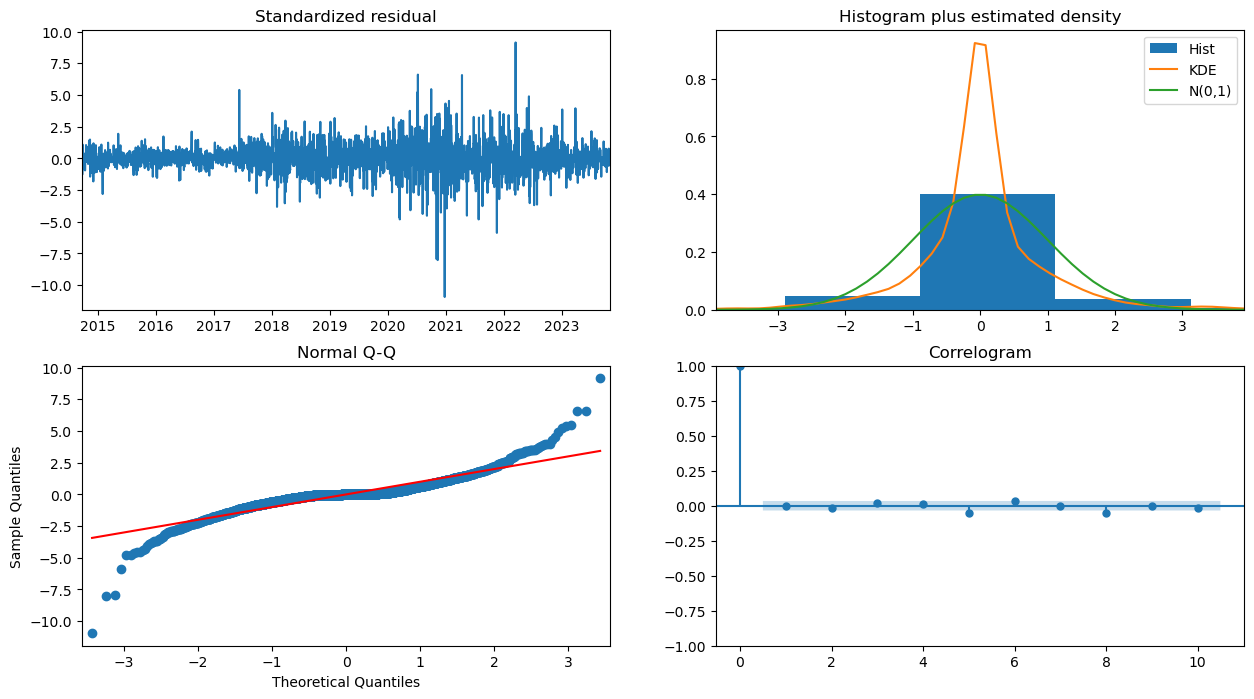

In [13]:
arima.get_data('BABA')
arima.parameters()
arima.split_data()
arima.model()

In [14]:
fig = arima.forecast()
fig

In [10]:
av = AlphaVantageAPI()

NameError: name 'AlphaVantageAPI' is not defined

NameError: name 'AlphaVantageAPI' is not defined

In [ ]:
ticker = 'IBM'
df = av.get_daily(ticker = ticker)
df.head()

In [ ]:
df.isnull().sum()

In [ ]:
df = df.asfreq('d')

In [ ]:
y = df['close']

In [ ]:
y.index

In [ ]:
df_log = np.log(y).dropna()
model_autoARIMA = auto_arima(df_log, start_p=0,
                             start_q=0, start_P=0,
                             start_Q=0, test='adf', error_action='trace')
get_parametes = model_autoARIMA.get_params()
summary = model_autoARIMA.summary()
summary

In [ ]:
df_log.index

In [ ]:
test_size = 0.01
limit = int(len(df_log) * test_size)
train = df_log.iloc[limit:]
test = df_log.iloc[:limit]
len_train = len(train)
len_test = len(test)
len_train,len_test

In [ ]:
train.index

In [ ]:
order_aa = get_parametes.get('order')
seasonal_order_aa = get_parametes.get('seasonal_order')
        
model = SARIMAX(train.close,
                     order = (order_aa[0], order_aa[1], order_aa[2]),
                     seasonal_order =(seasonal_order_aa[0],
                                      seasonal_order_aa[1], seasonal_order_aa[2], seasonal_order_aa[3]))
result = model.fit(disp=0)
summary =result.summary()
summary

In [ ]:
str(train.index[0])

In [ ]:
timestamp = train.index[0]

dt_object = datetime.fromtimestamp(timestamp)

print('Date and Time is:', dt_object)

In [ ]:
y_pred_wfv = result.predict(dynamic=False)
df_predictions = pd.DataFrame({"train" : train.close, "test" : test.close, "predict" : y_pred_wfv})
fig = px.line(df_predictions)
fig

In [ ]:
# Forecast
fc= result.forecast()  # 95% conf
# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train.close, label='training data')
plt.plot(test.close, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.title('ARCH CAPITAL GROUP Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('ARCH CAPITAL GROUP Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [ ]:
order_aa = get_parametes.get('order')
seasonal_order_aa = get_parametes.get('seasonal_order')
        
model_ar = ARIMA(train.close,
                     order = (order_aa[0], order_aa[1], order_aa[2]))
result_ar = model.fit()
summary_ar =result.summary()
summary_ar

In [ ]:
y_pred_wfv = result_ar.predict(dynamic=False)
df_predictions = pd.DataFrame({"train" : train.close, "test" : test.close, "predict" : y_pred_wfv})
fig = px.line(df_predictions)
fig

In [ ]:
test.index

In [ ]:
# Forecast
fc= result_ar.forecast(60)  # 95% conf
# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train.close, label='training data')
plt.plot(test.close, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.title('ARCH CAPITAL GROUP Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('ARCH CAPITAL GROUP Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [ ]:
y_train = train.close
y_test = test.close
y_test.index

In [ ]:
y_pred_wfv = pd.Series()
history = y_train.copy()
for i in range(len(y_test)):
    model = ARIMA(history, order = (8, 0, 1)).fit()
    next_pred = model.forecast()
    y_pred_wfv = y_pred_wfv.append(next_pred)
    history = history.append(y_test[next_pred.index])

In [ ]:
history

In [ ]:
len(y_test)

In [ ]:
df_predictions = pd.DataFrame({"y_test" : y_test, "y_pred_wfv" : y_pred_wfv})
fig = px.line(df_predictions)
fig.show()

In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv('stocks.csv')

In [ ]:
df.info()

In [ ]:
df.iloc[4538, 0] = 'NANO'

In [ ]:
df.info()